In [1]:
import sys, os, copy, re, random
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("whitegrid")
#palette = list(mcolors.TABLEAU_COLORS.keys())
#palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
palette = sns.color_palette(as_cmap=True)

In [2]:
# Empirically determined conversions within the linear range of
# a 3x replicate calibration curve.
def RR2Asp(RR):
    RR = np.array(RR)
    if (RR > 90).any():
        print('Warning: Asp concentration extrapolation (over)')
    if (RR < 0.07).any():
        print('Warning: Asp concentration extrapolation (under)')
    return(4.625997* (RR**1.065545))
def RR2Asn(RR):
    RR = np.array(RR)
    if (RR > 68).any():
        print('Warning: Asn concentration extrapolation (over)')
    if (RR < 0.07).any():
        print('Warning: Asn concentration extrapolation (under)')
    return(3.607991* (RR**1.017905))
def RR2Glu(RR):
    RR = np.array(RR)
    if (RR > 90).any():
        print('Warning: Glu concentration extrapolation (over)')
    if (RR < 0.07).any():
        print('Warning: Glu concentration extrapolation (under)')
    return(4.770099* (RR**1.056104))
def RR2Pro(RR):
    RR = np.array(RR)
    if (RR > 85).any():
        print('Warning: Pro concentration extrapolation (over)')
    if (RR < 0.07).any():
        print('Warning: Pro concentration extrapolation (under)')
    return(4.893499* (RR**1.067265))

## Setup
### Coulter counting based experiments
Two replicate proliferation experiments were setup with 2x wells for cell counting and 2x wells for metabolite extraction (replicate 1) and cell extraction for NAD+/NADH enzymatic assay (replicate 2). Each replicate experiment was started one week apart in the exact same way:
* Cell line: H1299 Nuclear RFP
* Plates: 12 well
* Media: DMEM dia. FBS, no pyruvate
* Seeding: 5000 cells/mL
* Initiation: One day after seeding, treatment added as 20x, then t0 was counted
* Treatments: 0, 15, 30, 60 nM rotenone and 60+Asp and 60+Pyr with 60 nM rotenone and 50 mM sodium aspartate and 2 mM pyruvate, respectively
* Sample times: 2, 3, 4, 5 days post initiation

For metabolite extracts, wells were washed thrice with cold saline and extracted with 1 mL 80% MeOH. Based on the Coulter counter measured cell volume, and equal cell volume was transferred to fresh tubes, dried and resuspended in mobile phase solvent with U-15N, U-13C amino acid internal standards.


### IncuCyte based experiments
To monitor cell counts non-invasively IncuCyte imaging was applied using the RFP channel to count RFP containing nuclei. The cells were seeded in 3x 24 well plates using otherwise similar setup, including media, seeding density etc. Each plate had 4 "well replicates" with the same treatment and 3 replicates of such plate was setup. After initiating the experiment with rotenone treatments, plates were moved to the IncuCyte and imaged with 16 fields-of-view every 6 hours for 7 days. At the end of the experiment, data was collected from the IncuCyte software by extracting the average of the well replicates from each plate such that each treatment has 3 replicate datapoints every 6 hours.

## Coulter counter data
Here, I am plotting cell counts and cell count derived data from two independent experiments, replicate 1 and 2. In replicate 1 a parallel experiment was done to extract metabolites and a parallel experiment of replicate 2 took samples for enzymatic NAD+/NADH ratio. As such the following will be plotted:
* Cell count over time (replicate 1/2)
* Proliferation over time (replicate 1/2)
* Aspartate/Asparagine/Proline/Glutamate/Rotenone over time (replicate 1)
* NAD+/NADH ratio over time (replicate 2)
* Proliferation as a function of Aspartate over time (replicate 1)
* Proliferation as a function of NAD+/NADH ratio over time (replicate 2)
* Aspartate as a function of NAD+/NADH ratio over time (replicate 1/2)

In [3]:
# Read Coulter Counter data:
df_CC = list(pd.read_excel('CC_data.xlsx', sheet_name=None).values())[0]
df_CC['Elapsed'] = [round(v, 3) for v in df_CC['Elapsed'].values]
df_CC_mean = df_CC.groupby(['Rep', 'Elapsed', 'Treatment']).mean(numeric_only=True).reset_index()
df_CC_stdev = df_CC.groupby(['Rep', 'Elapsed', 'Treatment']).std(numeric_only=True).reset_index()
df_CC

,Rotenone,Rescue,Treatment,Elapsed,Count,Cell-size_mean,Prlfr,Rep
0,0,Vehicle,0 nM,0.000,11933.333333,7969.666667,NaN,1
1,15,Vehicle,15 nM,0.000,11933.333333,7969.666667,NaN,1
2,30,Vehicle,30 nM,0.000,11933.333333,7969.666667,NaN,1
3,60,Vehicle,60 nM,0.000,11933.333333,7969.666667,NaN,1
4,60,Asp,60 nM + Asp,0.000,11933.333333,7969.666667,NaN,1
...,...,...,...,...,...,...,...,...
103,60,Vehicle,60 nM,5.018,19520.000000,15303.000000,0.251321,2
104,60,Asp,60 nM + Asp,5.018,35550.000000,11256.000000,0.423678,2
105,60,Asp,60 nM + Asp,5.018,28230.000000,11102.000000,0.357393,2
106,60,Pyr,60 nM + Pyr,5.018,77440.000000,10328.000000,0.647516,2


### Counts over time

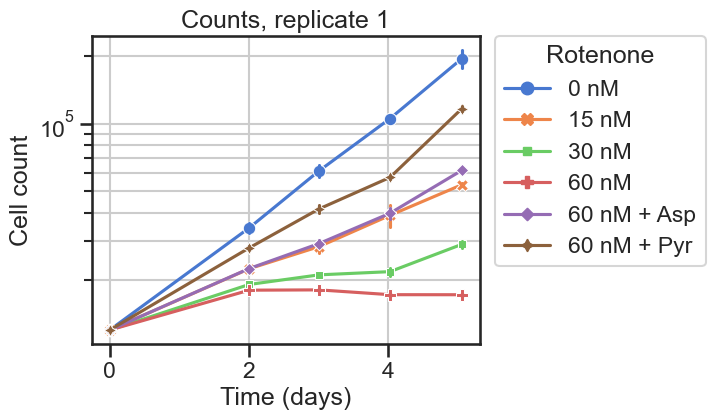

In [4]:
# Plot cell count for replicate 1 (metabolite extractions):
plt_out_nam = 'plots/count-time_rep1'
mask = df_CC['Rep'] == 1
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(data=df_CC[mask], x='Elapsed', y='Count', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set(yscale='log');
g1.grid(True, which='both')
g1.set_title('Counts, replicate 1');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Cell count');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_CC.loc[mask, ['Elapsed', 'Count', 'Treatment']]\
    .reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

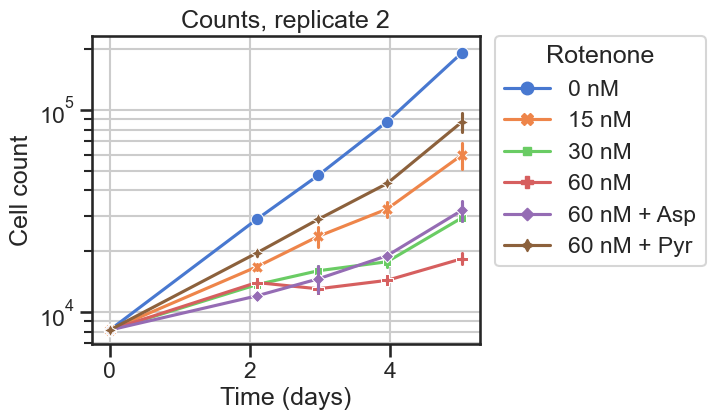

In [5]:
# Plot cell count for replicate 2 (NAD+/NADH levels):
plt_out_nam = 'plots/count-time_rep2'
mask = df_CC['Rep'] == 2
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(data=df_CC[mask], x='Elapsed', y='Count', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set(yscale='log');
g1.grid(True, which='both')
g1.set_title('Counts, replicate 2');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Cell count');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_CC.loc[mask, ['Elapsed', 'Count', 'Treatment']]\
    .reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

### Proliferation over time

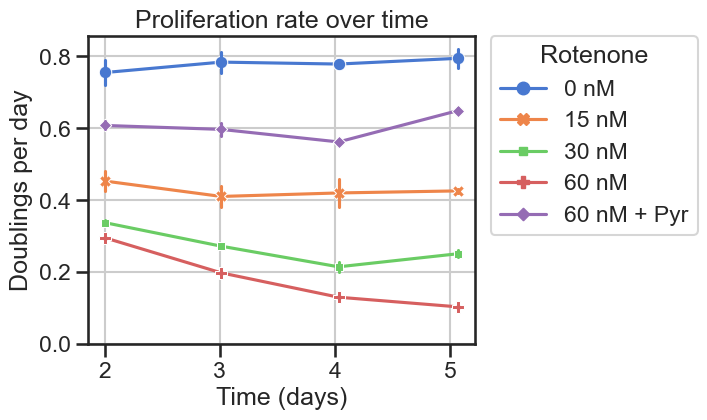

In [6]:
# Plot proliferation rate for replicate 1 (metabolite extractions):
# mask = df_CC['Rep'] == 1
plt_out_nam = 'plots/prlfr-time_rep1'
mask = (df_CC['Rep'] == 1) & (df_CC['Treatment'] != '60 nM + Asp')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(data=df_CC[mask], x='Elapsed', y='Prlfr', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
#g1.set(yscale='log');
g1.set_ylim(0, g1.get_ylim()[1])
g1.grid(True, which='both')
# g1.set_title('Proliferation rate, replicate 1');
g1.set_title('Proliferation rate over time');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Doublings per day');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_CC.loc[mask, ['Elapsed', 'Prlfr', 'Treatment']]\
    .reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

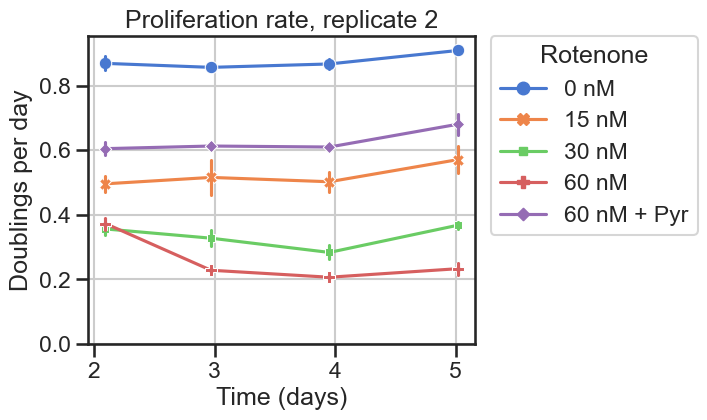

In [7]:
# Plot proliferation rate for replicate 2 (metabolite extractions):
# mask = df_CC['Rep'] == 2
plt_out_nam = 'plots/prlfr-time_rep2'
mask = (df_CC['Rep'] == 2) & (df_CC['Treatment'] != '60 nM + Asp')
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(data=df_CC[mask], x='Elapsed', y='Prlfr', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
#g1.set(yscale='log');
g1.set_ylim(0, g1.get_ylim()[1])
g1.grid(True, which='both')
g1.set_title('Proliferation rate, replicate 2');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Doublings per day');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_CC.loc[mask, ['Elapsed', 'Prlfr', 'Treatment']]\
    .reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

#### Conclusions
* 0/15 nM rotenone is roughly log-linear throughout the whole time-course.
* Higher rotenone concentrations appear to start out fast but slow down over time.
* Pyruvate provides a good rescue.
* Aspartate provides a moderate/small rescue.

In [8]:
df_CC.reset_index(drop=True)\
    .to_excel('dataframes/count_prlfr_dataframe.xlsx', index=False, sheet_name='count_prlfr')

### Metabolite data for replicate 1

In [9]:
# Read metabolite measurements:
metab_anno_df = pd.read_excel('H1299-Nuc-RFP_v1/metab_annotations.xlsx')
metab_anno_df['Elapsed'] = [round(v, 3) for v in metab_anno_df['Elapsed'].values]
metab_anno_df['Elapsed_int'] = [round(v) for v in metab_anno_df['Elapsed'].values]
# Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('H1299-Nuc-RFP_v1/H1299-Rotenone-time_metab.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['ISTD Response'] == 0) == 0:
            metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['ISTD Response']
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample ID'] = metab_dict_mes[k]['Sample ID']

        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(metab_anno_df, left_on='Sample ID', right_on='Sample ID')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['dilution']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details', 'Theoretical Amt'], axis=1)

# Create dataframe:
df_metab = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample ID'].equals(df_metab['Sample ID']))
    df_metab[nam] = metab_dict_mes[nam]['Response']
    
    # Convert to concentrations:
    if True:
        if 'Aspartate' in nam:
            df_metab['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
        elif 'Asparagine' in nam:
            df_metab['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
        elif 'Proline' in nam:
            df_metab['Proline conc'] = RR2Pro(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
        elif 'Glutamate' in nam:
            df_metab['Glutamate conc'] = RR2Pro(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['dilution'].values
# Flatten for Facetgrid plotting:
df_metab_flat = pd.melt(df_metab.drop(['dilution', 'Sample ID'], axis=1), id_vars=['Elapsed', 'Elapsed_int', 'Treatment']).rename(columns={'variable': 'Metabolite', 'value': 'Response'})
# Group mean, merge with count data, flatten:
df_metab_mean = df_metab.groupby(['Elapsed', 'Treatment']).mean(numeric_only=True).reset_index()
mask = (df_CC_mean['Rep'] == 1) & (df_CC_mean['Elapsed'] > 0)
df_metab_mean = df_metab_mean.merge(df_CC_mean[mask], left_on=['Elapsed', 'Treatment'], right_on=['Elapsed', 'Treatment']).drop(['Rep', 'dilution', 'Rotenone', 'Count'], axis=1)
df_metab_mean['Elapsed_int'] = [round(v) for v in df_metab_mean['Elapsed'].values]
df_metab_mean_flat = pd.melt(df_metab_mean, id_vars=['Elapsed', 'Elapsed_int', 'Treatment', 'Cell-size_mean', 'Prlfr']).rename(columns={'variable': 'Metabolite', 'value': 'Response'})
# Group standard deviation, merge with count data, flatten:
df_metab_stdev = df_metab.groupby(['Elapsed', 'Treatment']).std(numeric_only=True).reset_index()
mask = (df_CC_stdev['Rep'] == 1) & (df_CC_stdev['Elapsed'] > 0)
df_metab_stdev = df_metab_stdev.merge(df_CC_stdev[mask], left_on=['Elapsed', 'Treatment'], right_on=['Elapsed', 'Treatment']).drop(['Rep', 'dilution', 'Rotenone', 'Count'], axis=1)
df_metab_stdev['Elapsed_int'] = [round(v) for v in df_metab_stdev['Elapsed'].values]
df_metab_stdev_flat = pd.melt(df_metab_stdev, id_vars=['Elapsed', 'Elapsed_int', 'Treatment', 'Cell-size_mean', 'Prlfr']).rename(columns={'variable': 'Metabolite', 'value': 'Response'})

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


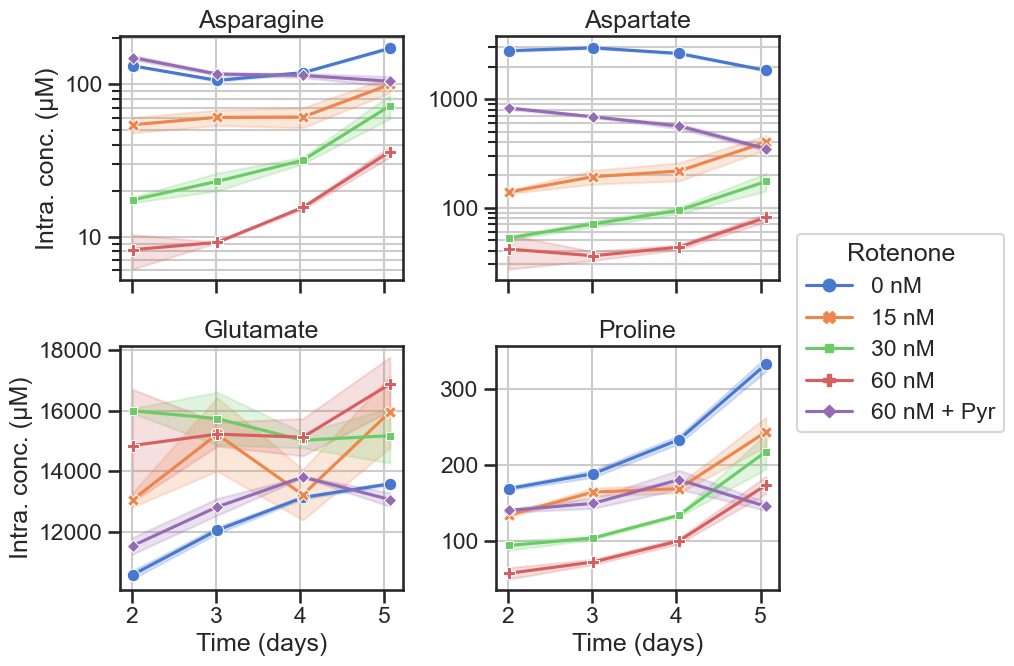

In [10]:
# Plot Asp/Asn/Glu/Pro:
# mask = df_metab_flat['Metabolite'].str.contains('conc')
plt_out_nam = 'plots/Asn-Asp-Glu-Pro-time_rep1'
mask = (df_metab_flat['Metabolite'].str.contains('conc')) & (df_metab_flat['Treatment'] != '60 nM + Asp')
df_plot = df_metab_flat[mask]
df_plot.loc[:, 'Metabolite'] = [v[:-5] for v in df_plot['Metabolite'].values]
sns_fig = sns.FacetGrid(df_plot, col='Metabolite', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=False, sharex=True)
sns_fig.map_dataframe(sns.lineplot, x='Elapsed', y='Response', errorbar=('ci', 95), hue='Treatment', style='Treatment', markers=True, dashes=False)
#for _, ax in sns_fig.axes_dict.items():
#    ax.grid(True, which='both')

sns_fig.set_axis_labels('Time (days)', 'Intra. conc. (μM)')
sns_fig.set_titles(col_template='{col_name}')
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.81, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
# Specify log y-axis and the tick label formating:
for ax in sns_fig.axes.flatten():
    ax.grid(True, which='both')
    if ax.get_title() in ['Asparagine', 'Aspartate']:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
        ax.yaxis.set_minor_formatter(tck.LogFormatter())
sns_fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_plot.rename({'Response': 'Conc (uM)'}, axis=1).reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

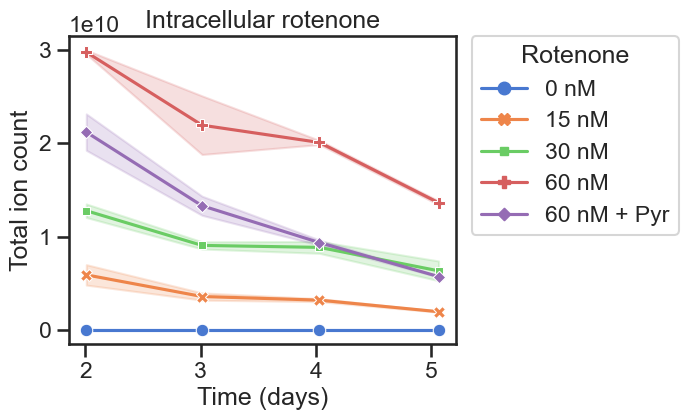

In [11]:
# Plot intracellular rotenone:
plt_out_nam = 'plots/intra-rotenone-time_rep1'
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
mask = (df_metab['Treatment'] != '60 nM + Asp')
g1 = sns.lineplot(ax=ax1, data=df_metab[mask], x='Elapsed', y='Rotenone pos', hue='Treatment', style='Treatment', markers=True, dashes=False, zorder=20)
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_title('Intracellular rotenone');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Total ion count');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_metab.loc[mask, ['Elapsed', 'Treatment', 'Rotenone pos']].reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

#### Conclusions
* Aspartate levels decrease with more rotenone. Pyruvate and aspartate supplementation rescue.
* Aspartate levels for 15/30/60 nM rotenone samples increase over time. Unlikely, to be a result of media conditioning but could be due to reduced levels of rotenone as it breaks down over time.
* Asparagine levels track aspartate levels with the exception of aspartate supplemented cells.
* Asparagine levels increases over time, likely due to media conditioning.
* Glutamate levels are generally higher in respiration inhibited conditions, maybe due to reduced glutamate dehydrogenase activity.
* Proline accumulates (media conditioning) slower in respiration inhibited conditions.

In [12]:
df_metab.reset_index(drop=True)\
    .to_excel('dataframes/metab_dataframe.xlsx', index=False, sheet_name='metab')

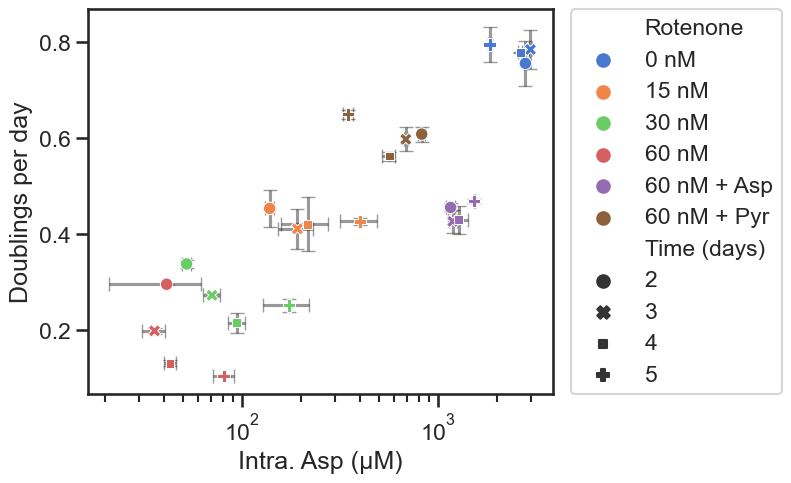

In [13]:
# Plot proliferation rate as a function of aspartate:
plt_out_nam = 'plots/intra-asp-prlfr_rep1'
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
g1 = sns.scatterplot(ax=ax1, data=df_metab_mean, x='Aspartate conc', y='Prlfr', hue='Treatment', style='Elapsed_int', zorder=20)
g1.errorbar(y=df_metab_mean['Prlfr'].values, x=df_metab_mean['Aspartate conc'].values, yerr=df_metab_stdev['Prlfr'].values, xerr=df_metab_stdev['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Change legend subtitles:
new_labels = g1.get_legend_handles_labels()[1]
ridx = new_labels.index('Treatment')
new_labels[ridx] = 'Rotenone'
ridx = new_labels.index('Elapsed_int')
new_labels[ridx] = 'Time (days)'
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='', labels=new_labels, handles=g1.get_legend_handles_labels()[0]);
g1.set(xscale='log');
#g1.set_title('ggggg');
g1.set_xlabel('Intra. Asp (μM)')
g1.set_ylabel('Doublings per day');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_metab_mean.loc[:, ['Elapsed_int', 'Treatment', 'Aspartate conc', 'Prlfr']]\
    .merge(df_metab_stdev.loc[:, ['Elapsed_int', 'Treatment', 'Aspartate conc', 'Prlfr']], \
           on=['Elapsed_int', 'Treatment'], suffixes=('_mean', '_stdev'))\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


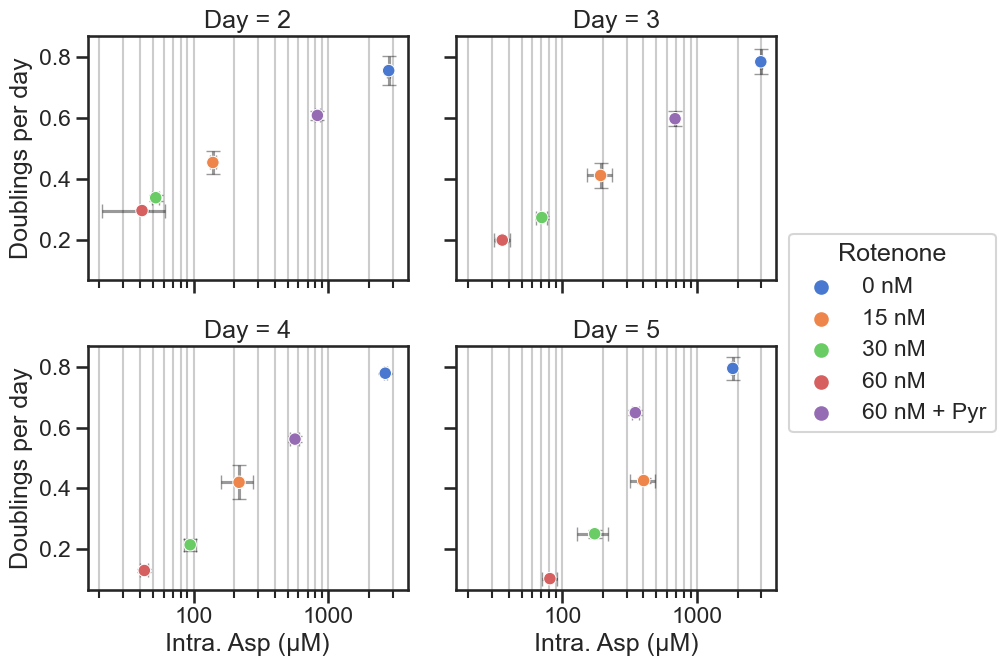

In [14]:
# Proliferation as a function of intracellular aspartate, day by day:
# mask = df_metab_mean_flat['Metabolite'].str.contains('Aspartate conc')
plt_out_nam = 'plots/intra-asp-prlfr_rep1-byday'
mask = (df_metab_mean_flat['Metabolite'].str.contains('Aspartate conc')) & (df_metab_mean_flat['Treatment'] != '60 nM + Asp')
df_plot = df_metab_mean_flat[mask]
df_plot['stdev_asp'] = df_metab_stdev_flat[mask]['Response'].values
df_plot['stdev_prlfr'] = df_metab_stdev_flat[mask]['Prlfr'].values
sns_fig = sns.FacetGrid(df_plot, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=True, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='Response', y='Prlfr', hue='Treatment', zorder=20)
for _, ax in sns_fig.axes_dict.items():
    ax.grid(True, which='both', axis='x')

sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.77, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map_dataframe(plt.errorbar, x='Response', y='Prlfr', xerr='stdev_asp', yerr='stdev_prlfr', fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('Intra. Asp (μM)', 'Doublings per day')
# Specify log y-axis and the tick label formating:
for ax in sns_fig.axes.flatten():
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
    ax.xaxis.set_minor_formatter(tck.LogFormatter())
sns_fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_metab_mean.loc[:, ['Elapsed_int', 'Treatment', 'Aspartate conc', 'Prlfr']]\
    .merge(df_metab_stdev.loc[:, ['Elapsed_int', 'Treatment', 'Aspartate conc', 'Prlfr']], \
           on=['Elapsed_int', 'Treatment'], suffixes=('_mean', '_stdev'))\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

#### Conclusions
* Aspartate levels track with proliferation except when aspartate is supplemented.
* Aspartate supplementation increases intracellular aspartate but does not rescue proliferation to the same degree as the Aspartate-to-Proliferation relationship otherwise displayed by rotenone titration.

### NAD+/NADH data for replicate 2

In [15]:
# Read NAD+/NADH data:
df_NAD = pd.read_excel('H1299-Nuc-RFP_v2/NAD-NADH_data.xlsx')
df_NAD['Elapsed'] = [round(v, 3) for v in df_NAD['Elapsed'].values]
df_NAD['Elapsed_int'] = [round(v) for v in df_NAD['Elapsed'].values]
# Group mean, merge with count data:
df_NAD_mean = df_NAD.groupby(['Elapsed', 'Treatment']).mean().reset_index()
mask = (df_CC_mean['Rep'] == 2) & (df_CC_mean['Elapsed'] > 0)
df_NAD_mean = df_NAD_mean.merge(df_CC_mean[mask], left_on=['Elapsed', 'Treatment'], right_on=['Elapsed', 'Treatment']).drop(['Rep', 'Rotenone', 'Count'], axis=1)
df_NAD_mean['Elapsed_int'] = [round(v) for v in df_NAD_mean['Elapsed'].values]
# Group standard deviation, merge with count data:
df_NAD_stdev = df_NAD.groupby(['Elapsed', 'Treatment']).std().reset_index()
mask = (df_CC_stdev['Rep'] == 2) & (df_CC_stdev['Elapsed'] > 0)
df_NAD_stdev = df_NAD_stdev.merge(df_CC_stdev[mask], left_on=['Elapsed', 'Treatment'], right_on=['Elapsed', 'Treatment']).drop(['Rep', 'Rotenone', 'Count'], axis=1)
df_NAD_stdev['Elapsed_int'] = [round(v) for v in df_NAD_stdev['Elapsed'].values]

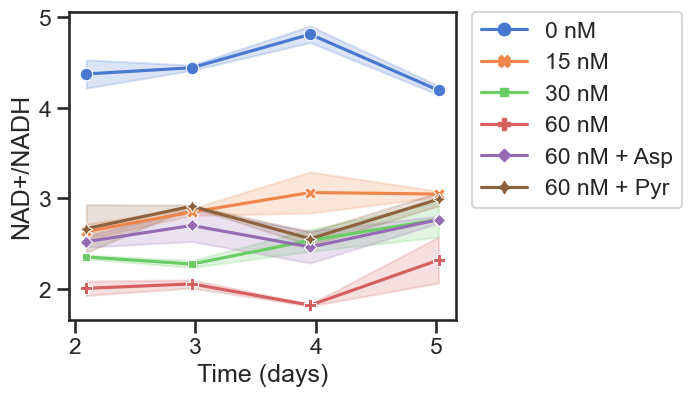

In [16]:
# Plot NAD+/NADH ratio over time:
plt_out_nam = 'plots/NAD-NADH-time_rep2'
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(ax=ax1, data=df_NAD, x='Elapsed', y='NAD-NADH', hue='Treatment', style='Treatment', markers=True, dashes=False, zorder=20)
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='');
g1.set_xlabel('Time (days)')
g1.set_ylabel('NAD+/NADH');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_NAD.loc[:, ['Elapsed', 'Treatment', 'NAD-NADH']].reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

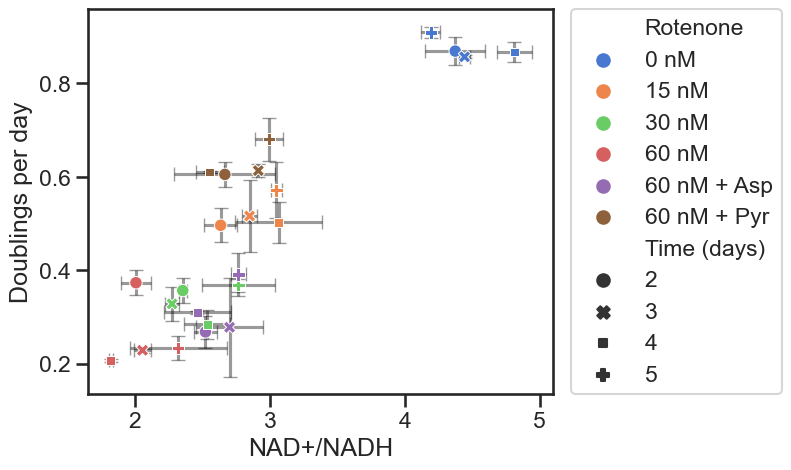

In [17]:
# Plot proliferation rate as a function of NAD+/NADH ratio:
plt_out_nam = 'plots/NAD-NADH-prlfr_rep2'
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
g1 = sns.scatterplot(ax=ax1, data=df_NAD_mean, x='NAD-NADH', y='Prlfr', hue='Treatment', style='Elapsed_int', zorder=20)
g1.errorbar(y=df_NAD_mean['Prlfr'].values, x=df_NAD_mean['NAD-NADH'].values, yerr=df_NAD_stdev['Prlfr'].values, xerr=df_NAD_stdev['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Change legend subtitles:
new_labels = g1.get_legend_handles_labels()[1]
ridx = new_labels.index('Treatment')
new_labels[ridx] = 'Rotenone'
ridx = new_labels.index('Elapsed_int')
new_labels[ridx] = 'Time (days)'
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='', labels=new_labels, handles=g1.get_legend_handles_labels()[0]);
g1.set_xlabel('NAD+/NADH')
g1.set_ylabel('Doublings per day');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_NAD_mean.loc[:, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Prlfr']]\
    .merge(df_NAD_stdev.loc[:, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Prlfr']], \
           on=['Elapsed_int', 'Treatment'], suffixes=('_mean', '_stdev'))\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


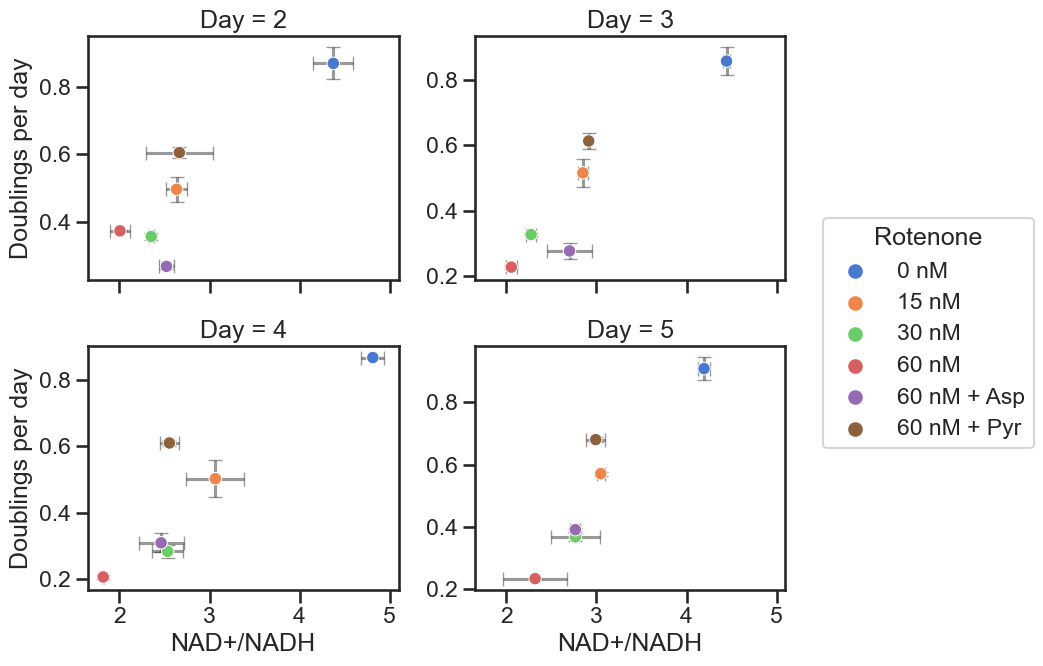

In [18]:
# Proliferation as a function of NAD+/NADH, day by day:
plt_out_nam = 'plots/NAD-NADH-prlfr_rep2-byday'
df_plot = copy.deepcopy(df_NAD_mean)
df_plot['stdev_NAD'] = df_NAD_stdev['NAD-NADH'].values
df_plot['stdev_prlfr'] = df_metab_stdev['Prlfr'].values
sns_fig = sns.FacetGrid(df_plot, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=False, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='NAD-NADH', y='Prlfr', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map_dataframe(plt.errorbar, x='NAD-NADH', y='Prlfr', xerr='stdev_NAD', yerr='stdev_prlfr', fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('NAD+/NADH', 'Doublings per day')
sns_fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_NAD_mean.loc[:, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Prlfr']]\
    .merge(df_NAD_stdev.loc[:, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Prlfr']], \
           on=['Elapsed_int', 'Treatment'], suffixes=('_mean', '_stdev'))\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

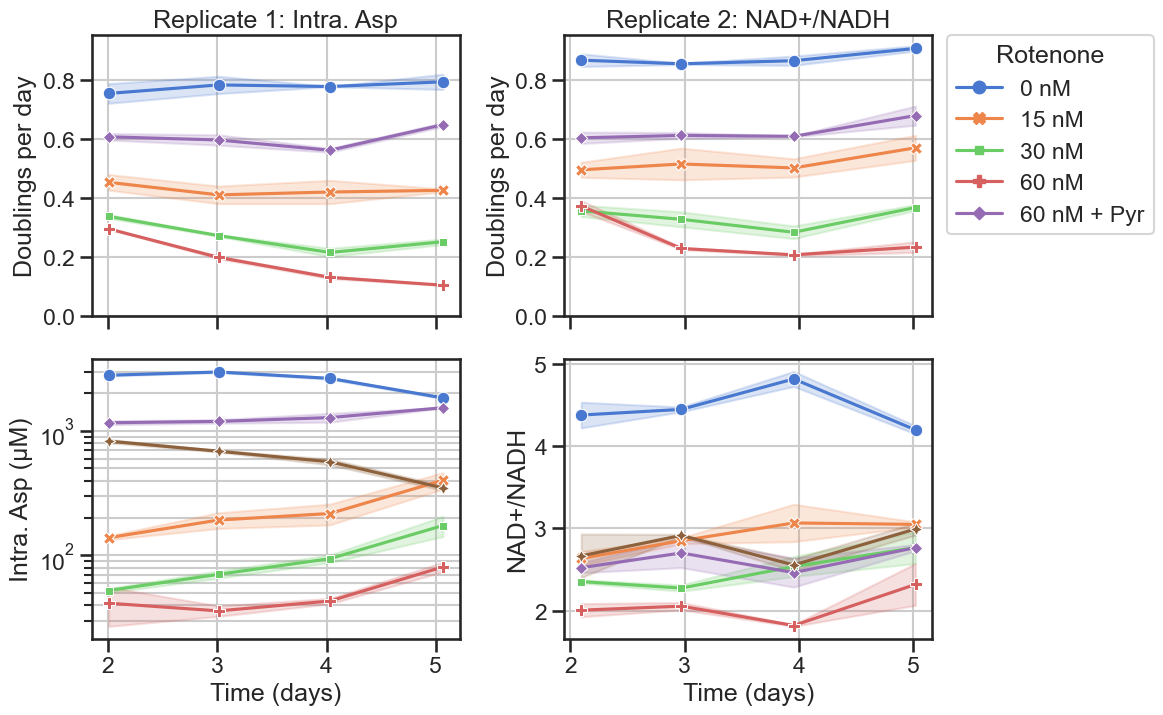

In [19]:
### Combined plot with proliferation rate, Asp and NAD/NADH over time ###
fig, axes = plt.subplots(2, 2, figsize=(12, 7.5), sharex='col')

# Plot replicate 1 in first column #
# Proliferation rate:
# mask = df_CC['Rep'] == 1
mask = (df_CC['Rep'] == 1) & (df_CC['Treatment'] != '60 nM + Asp')
g1 = sns.lineplot(ax=axes[0, 0], data=df_CC[mask], x='Elapsed', y='Prlfr', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False)
g1.legend_.remove()
#g1.set_ylim(0, g1.get_ylim()[1])
g1.grid(True, which='both')
g1.set_title('Replicate 1: Intra. Asp');
g1.set_ylabel('Doublings per day');
# Aspartate conc.:
g2 = sns.lineplot(ax=axes[1, 0], data=df_metab, x='Elapsed', y='Aspartate conc', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False)
g2.set(yscale='log');
g2.legend_.remove()
g2.grid(True, which='both')
g2.set_xlabel('Time (days)')
g2.set_ylabel('Intra. Asp (μM)');

# Plot replicate 2 in second column #
# Proliferation rate:
# mask = df_CC['Rep'] == 2
mask = (df_CC['Rep'] == 2) & (df_CC['Treatment'] != '60 nM + Asp')
g3 = sns.lineplot(ax=axes[0, 1], data=df_CC[mask], x='Elapsed', y='Prlfr', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False)
#g3.legend_.remove()
g3.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone')
g3.set_ylim(0, g3.get_ylim()[1])
g1.set_ylim(0, g3.get_ylim()[1])
g3.grid(True, which='both')
g3.set_title('Replicate 2: NAD+/NADH');
g3.set_ylabel('Doublings per day');
# Aspartate conc.:
g4 = sns.lineplot(ax=axes[1, 1], data=df_NAD, x='Elapsed', y='NAD-NADH', hue='Treatment', style='Treatment', markers=True, dashes=False)
g4.legend_.remove()
g4.grid(True, which='both')
g4.set_xlabel('Time (days)')
g4.set_ylabel('NAD+/NADH');

# Save:
fig.tight_layout()
# fig.savefig('plots/prlfr-asp-NAD-NADH-time_rep1-2.pdf', bbox_inches='tight');

#### Conclusions
* NAD+/NADH ratios decrease with rotenone and increase with both aspartate and pyruvate supplementation.
* NAD+/NADH ratios in rotenone treated cells slightly increase over time, likely reflecting the decrease in media rotenone.
* NAD+/NADH ratio track with proliferation rate, most clearly seen at the day 5 sampling (which is the most accurate due to longer time to proliferate = smaller seeding variance).
* Aspartate supplementation does not break the correlation between NAD+/NADH ratio and proliferation.

In [20]:
df_NAD.reset_index(drop=True)\
    .to_excel('dataframes/NAD-NADH_dataframe.xlsx', index=False, sheet_name='NAD-NADH')

### Asparate as a function of NAD+/NADH

In [21]:
# Merge the data from replicate 1 and 2:
df_metab_NAD_mean = df_NAD_mean.merge(df_metab_mean, left_on=['Treatment', 'Elapsed_int'], right_on=['Treatment', 'Elapsed_int'])
df_metab_NAD_stdev = df_NAD_stdev.merge(df_metab_stdev, left_on=['Treatment', 'Elapsed_int'], right_on=['Treatment', 'Elapsed_int'])

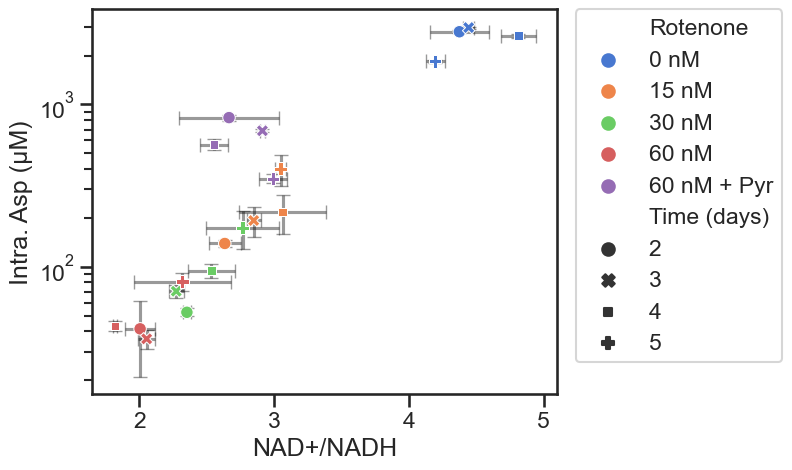

In [22]:
# Plot aspartate as a function of NAD+/NADH:
plt_out_nam = 'plots/NAD-NADH-Asp_rep1-2'
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
mask = df_metab_NAD_mean['Treatment'] != '60 nM + Asp'
g1 = sns.scatterplot(ax=ax1, data=df_metab_NAD_mean[mask], x='NAD-NADH', y='Aspartate conc', hue='Treatment', style='Elapsed_int', zorder=20)
g1.errorbar(y=df_metab_NAD_mean[mask]['Aspartate conc'].values, x=df_metab_NAD_mean[mask]['NAD-NADH'].values, yerr=df_metab_NAD_stdev[mask]['Aspartate conc'].values, xerr=df_metab_NAD_stdev[mask]['NAD-NADH'].values, fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Change legend subtitles:
new_labels = g1.get_legend_handles_labels()[1]
ridx = new_labels.index('Treatment')
new_labels[ridx] = 'Rotenone'
ridx = new_labels.index('Elapsed_int')
new_labels[ridx] = 'Time (days)'
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='', labels=new_labels, handles=g1.get_legend_handles_labels()[0]);
g1.set(yscale='log');
g1.set_xlabel('NAD+/NADH')
g1.set_ylabel('Intra. Asp (μM)');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_metab_NAD_mean.loc[mask, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Aspartate conc']]\
    .merge(df_metab_NAD_stdev.loc[mask, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Aspartate conc']], \
           on=['Elapsed_int', 'Treatment'], suffixes=('_mean', '_stdev'))\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


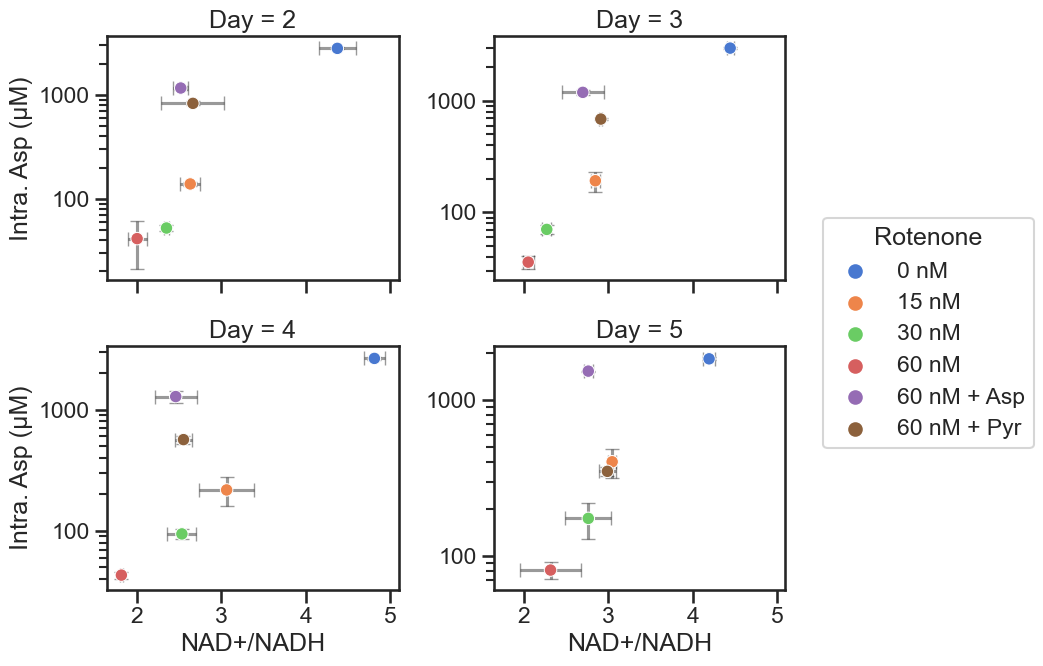

In [23]:
# Plot aspartate as a function of NAD+/NADH,
# on a day-by-day basis:
plt_out_nam = 'plots/NAD-NADH-Asp_rep1-2-byday'
df_plot = copy.deepcopy(df_metab_NAD_mean)
df_plot['stdev_NAD'] = df_NAD_stdev['NAD-NADH'].values
df_plot['stdev_asp'] = df_metab_stdev['Aspartate conc'].values
sns_fig = sns.FacetGrid(df_plot, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=False, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='NAD-NADH', y='Aspartate conc', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map_dataframe(plt.errorbar, x='NAD-NADH', y='Aspartate conc', xerr='stdev_NAD', yerr='stdev_asp', fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('NAD+/NADH', 'Intra. Asp (μM)')
# Specify log y-axis and the tick label formating:
for ax in sns_fig.axes.flatten():
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
    ax.yaxis.set_minor_formatter(tck.LogFormatter())
sns_fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_metab_NAD_mean.loc[mask, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Aspartate conc']]\
    .merge(df_metab_NAD_stdev.loc[mask, ['Elapsed_int', 'Treatment', 'NAD-NADH', 'Aspartate conc']], \
           on=['Elapsed_int', 'Treatment'], suffixes=('_mean', '_stdev'))\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

#### Conclusions
* NAD+/NADH ratios dictate intracellular aspartate levels under rotenone treatment.
* Pyruvate rescues aspartate be increasing NAD+/NADH (see day 5).
* Aspartate supplementation increases intracellular aspartate disproportionately to its increase in NAD+/NADH ratio.

## IncuCyte data
IncuCyte (IC) can be used to minitor cell counts over time in a non-invasive way by imaging. Whereas Coulter counter (CC) based cell count over time rely on replicate plates, and thus are sensitive to cell seeding variance, IncuCyte monitors the same well over time. To count cells with the IncuCyte image software a nuclear localized RFP was used. A phase contrast and an RFP image was taken every 6 hours after rotenone treatment until the end of the experiment. Cell were then counted based on discrete RFP expressing nuclei. The purpose of this experiment is to show that the IncuCyte platform can be used to quantify cell proliferation with high time resolution and precision.
As such the following will be plotted:
* Cell count over time.
* Proliferation over time as compared to replicate 1/2.

In [24]:
# Read the IncuCyte data:
IC_anno = list(pd.read_excel('H1299_IncuCyte-Prlfr/IC_annotations.xlsx', sheet_name=None).values())[0]
IC_folder = 'H1299_IncuCyte-Prlfr/data_per-column/'
frames = list()
# Read IncuCyte counts:
for rep in range(1, 4):
    fn = IC_folder + 'Rep' + str(rep) + '.txt'
    df_tmp = pd.read_csv(fn, sep='\t', skiprows=1)
    df_tmp['Rep'] = rep
    frames.append(df_tmp)
df_IC = pd.concat(frames)
df_IC = df_IC.drop('Date Time', axis=1)
df_IC['Elapsed'] = df_IC['Elapsed'].values/24
df_IC_flat = pd.melt(df_IC, id_vars=['Elapsed', 'Rep']).rename(columns={'variable': 'Column', 'value': 'Count'})
df_IC_flat = df_IC_flat.merge(IC_anno, left_on='Column', right_on='Column')
df_IC

,Elapsed,Column 1,Column 2,Column 3,Column 4,Column 5,Column 6,Rep
0,0.00,5871.625,5220.797,4980.047,4682.875,4933.938,5676.859,1
1,0.25,6845.172,5912.594,5600.031,5174.797,5436.109,6635.094,1
2,0.50,7941.703,6998.828,6501.828,6004.797,6204.703,7864.813,1
3,0.75,9063.781,7659.813,7331.969,6609.453,7096.250,8797.391,1
4,1.00,10570.250,8387.484,7793.047,6957.859,7357.531,9765.813,1
...,...,...,...,...,...,...,...,...
26,6.50,217266.200,158776.000,69726.480,20633.700,66472.780,179492.200,3
27,6.75,203441.700,177273.600,82346.830,23621.050,74040.880,190846.900,3
28,7.00,196037.600,197047.000,96904.060,26536.520,80415.110,198184.500,3
29,7.25,194725.800,215985.100,113669.700,31004.640,87624.580,200116.100,3


In [25]:
df_IC_flat.reset_index(drop=True)\
    .to_excel('dataframes/IncuCyte_counts_dataframe.xlsx', index=False, sheet_name='IC_counts')

### Counts over time

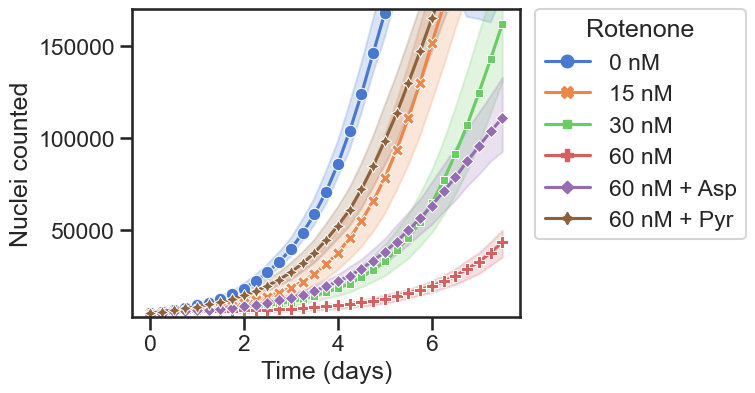

In [26]:
# Plot counts over time:
plt_out_nam = 'plots/IC_count-time'
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(ax=ax1, data=df_IC_flat, x='Elapsed', y='Count', hue='Treatment', style='Treatment', markers=True, dashes=False)
g1.set_ylim(3000, 170000)
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Nuclei counted');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_IC_flat.loc[:, ['Elapsed', 'Treatment', 'Count']].reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])

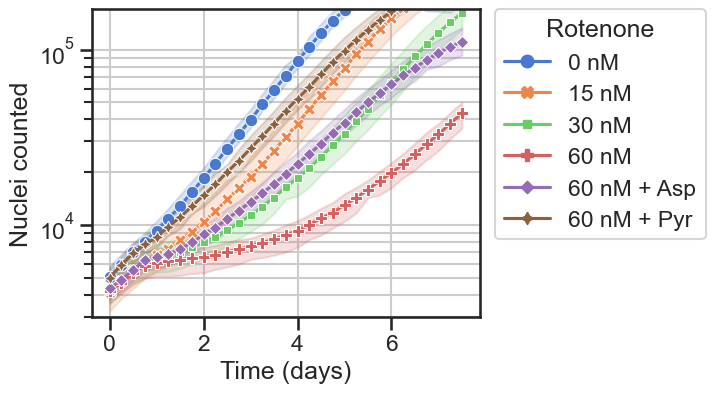

In [27]:
# Plot counts over time:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(ax=ax1, data=df_IC_flat, x='Elapsed', y='Count', hue='Treatment', style='Treatment', markers=True, dashes=False)
g1.set_ylim(3000, 170000)
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set(yscale='log');
g1.grid(True, which='both')
g1.set_xlabel('Time (days)')
g1.set_ylabel('Nuclei counted');
# fig.savefig('plots/IC_count-time_log.pdf', bbox_inches='tight');

In [28]:
### Add Prlfr inferred from IncuCyte data at same timepoint as Coulter counts ###
row_list = list() # Store data for dataframe
# Iterate over deduplicated data:
iter_el = list(dict.fromkeys([(v1, v2, v3) for v1, v2, v3 in zip(df_CC['Elapsed'].values, df_CC['Treatment'].values, df_CC['Rep'].values)]))
for row in iter_el:
    new_row = list()
    elapsed_days = row[0]
    new_row.append(elapsed_days)
    trmt = row[1]
    new_row.append(trmt)
    new_row.append(row[2])
    if elapsed_days*24 < 6:
        new_row.append(np.nan)
        row_list.append(new_row)
        continue
    # There are 3 replicates:
    for rep in range(1, 4):
        # Pick closest timepoint using +/- 3 h,
        # also pick out t=0:
        mask1 = (df_IC_flat['Rep'] == rep) & (df_IC_flat['Treatment'] == trmt) & \
        (((df_IC_flat['Elapsed'] < elapsed_days+3/24) & (df_IC_flat['Elapsed'] > elapsed_days-3/24)) | (df_IC_flat['Elapsed'] == 0))
        x = df_IC_flat[mask1]['Elapsed'].values
        y = df_IC_flat[mask1]['Count'].values
        inds = x.argsort() # sort index
        x = x[inds]
        y = y[inds]
        k = (np.log2(y[1]) - np.log2(y[0])) / (x[1]- x[0])
        new_row.append(k)
    row_list.append(new_row)

# Convert to flat dataframe:
df_IC_CC_inferred = pd.DataFrame(row_list, columns=['Elapsed', 'Treatment', 'Rep', '1', '2', '3'])
df_IC_CC_inferred = pd.melt(df_IC_CC_inferred, id_vars=['Elapsed', 'Treatment', 'Rep']).rename(columns={'variable': 'IC_Rep', 'value': 'Prlfr'})
df_IC_CC_inferred['IC_Rep'] = [int(v) for v in df_IC_CC_inferred['Rep'].values]
df_IC_CC_inferred_mean = df_IC_CC_inferred.groupby(['Elapsed', 'Treatment', 'Rep']).mean().reset_index().drop('IC_Rep', axis=1)
df_IC_CC_inferred_mean = df_IC_CC_inferred_mean.merge(df_CC_mean, left_on=['Elapsed', 'Rep', 'Treatment'], right_on=['Elapsed', 'Rep', 'Treatment']).drop(['Rotenone', 'Count'], axis=1).rename(columns={'Prlfr_x': 'Prlfr_IC', 'Prlfr_y': 'Prlfr_CC'})
df_IC_CC_inferred_mean['Elapsed_int'] = [round(v) for v in df_IC_CC_inferred_mean['Elapsed'].values]
df_IC_CC_inferred_stdev = df_IC_CC_inferred.groupby(['Elapsed', 'Treatment', 'Rep']).std().reset_index().drop('IC_Rep', axis=1)
df_IC_CC_inferred_stdev = df_IC_CC_inferred_stdev.merge(df_CC_stdev, left_on=['Elapsed', 'Rep', 'Treatment'], right_on=['Elapsed', 'Rep', 'Treatment']).drop(['Rotenone', 'Count'], axis=1).rename(columns={'Prlfr_x': 'Prlfr_IC', 'Prlfr_y': 'Prlfr_CC'})
df_IC_CC_inferred_stdev['Elapsed_int'] = [round(v) for v in df_IC_CC_inferred_stdev['Elapsed'].values]

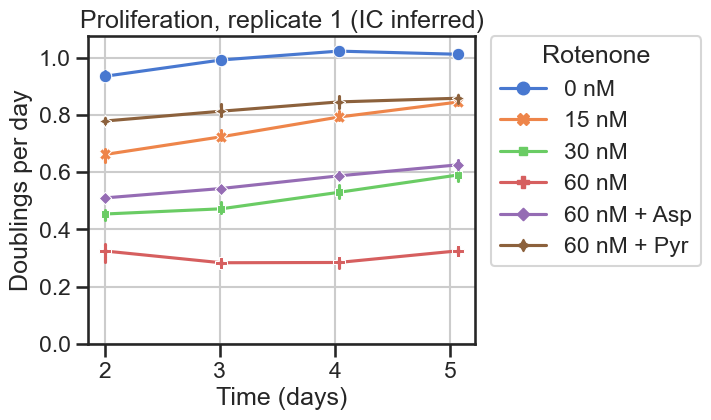

In [29]:
# Plot replicate 1 (metabolite extractions):
mask = df_IC_CC_inferred['Rep'] == 1
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(data=df_IC_CC_inferred[mask], x='Elapsed', y='Prlfr', hue='Treatment', \
                  style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_ylim(0, g1.get_ylim()[1])
g1.grid(True, which='both')
g1.set_title('Proliferation, replicate 1 (IC inferred)');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Doublings per day');
#fig.savefig('plots/prlfr-time_rep1_IC-inferred.pdf', bbox_inches='tight');

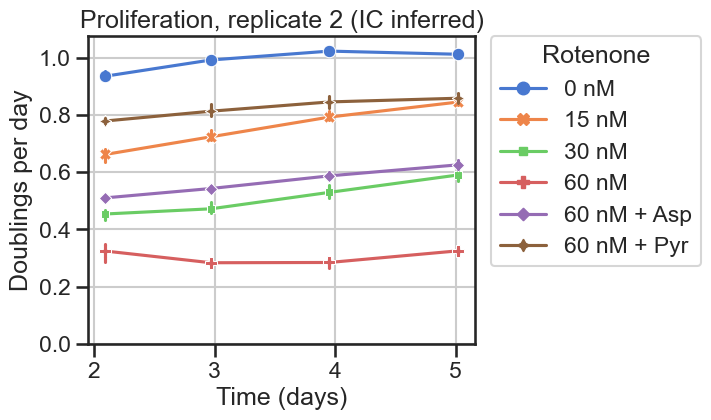

In [30]:
# Plot replicate 2 (NAD+/NADH ratio):
mask = df_IC_CC_inferred['Rep'] == 2
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
g1 = sns.lineplot(data=df_IC_CC_inferred[mask], x='Elapsed', y='Prlfr', hue='Treatment', \
                  style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_ylim(0, g1.get_ylim()[1])
g1.grid(True, which='both')
g1.set_title('Proliferation, replicate 2 (IC inferred)');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Doublings per day');
#fig.savefig('plots/prlfr-time_rep2_IC-inferred.pdf', bbox_inches='tight');

#### Conclusions
* Proliferation is not constant over time.
* During the first day post-rotenone, proliferation has not yet slowed much.
* Around day one there is an infliction point were proliferation slows as a response to rotenone, then it picks up again slowly the following days.
* IC proliferation trend over time does not match the trend from Coulter counter data.

### Comparing Coulter counter vs IncuCyte based cell counting

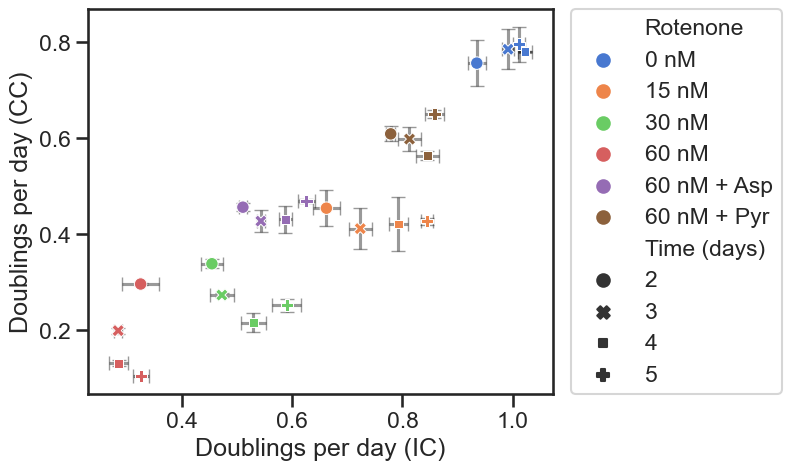

In [31]:
# Compare IC vs CC proliferation rate:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))
mask = (df_IC_CC_inferred_mean['Elapsed'] > 0) & (df_IC_CC_inferred_mean['Rep'] == 1)
g1 = sns.scatterplot(ax=ax1, data=df_IC_CC_inferred_mean[mask], x='Prlfr_IC', y='Prlfr_CC', hue='Treatment', style='Elapsed_int', zorder=20)
g1.errorbar(x=df_IC_CC_inferred_mean[mask]['Prlfr_IC'].values, y=df_IC_CC_inferred_mean[mask]['Prlfr_CC'].values, xerr=df_IC_CC_inferred_stdev[mask]['Prlfr_IC'].values, yerr=df_IC_CC_inferred_stdev[mask]['Prlfr_CC'].values, fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Change legend subtitles:
new_labels = g1.get_legend_handles_labels()[1]
ridx = new_labels.index('Treatment')
new_labels[ridx] = 'Rotenone'
ridx = new_labels.index('Elapsed_int')
new_labels[ridx] = 'Time (days)'
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='', labels=new_labels, handles=g1.get_legend_handles_labels()[0]);
g1.set_xlabel('Doublings per day (IC)')
g1.set_ylabel('Doublings per day (CC)');
# fig.savefig('plots/prlfr_ICvsCC.pdf', bbox_inches='tight');

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


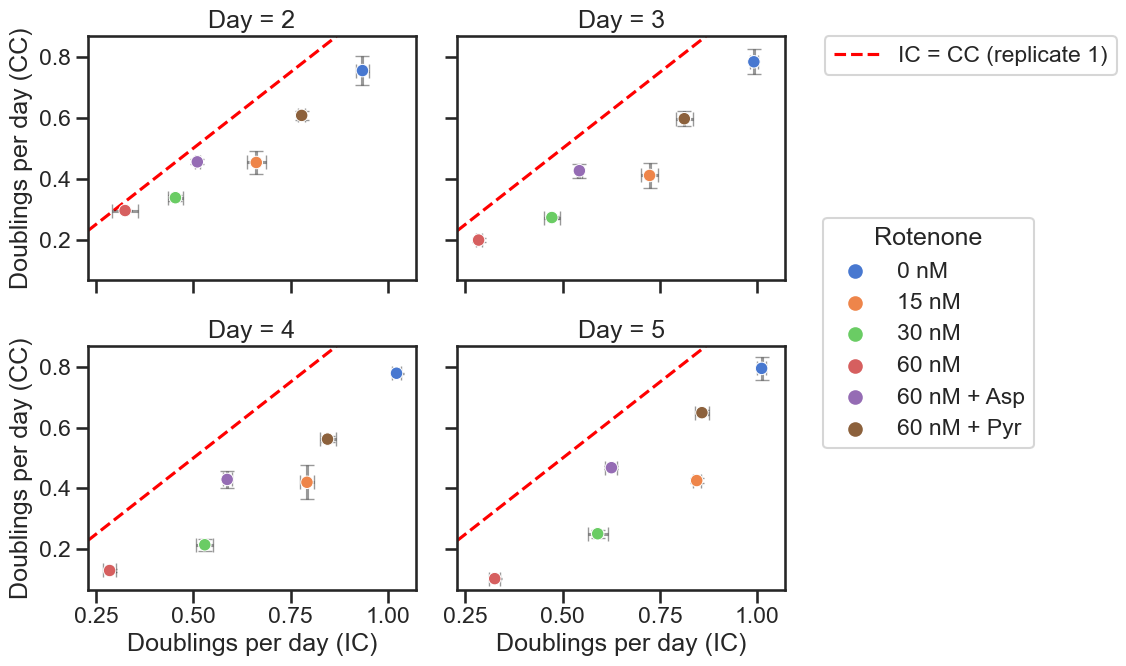

In [32]:
# Compare IC vs CC (rep 1) proliferation rate day-by-day:
mask = (df_IC_CC_inferred_mean['Elapsed'] > 0) & (df_IC_CC_inferred_mean['Rep'] == 1)
df_plot1 = copy.deepcopy(df_IC_CC_inferred_mean[mask])
df_plot1['stdev_IC'] = df_IC_CC_inferred_stdev[mask]['Prlfr_IC'].values
df_plot1['stdev_CC'] = df_IC_CC_inferred_stdev[mask]['Prlfr_CC'].values
sns_fig = sns.FacetGrid(df_plot1, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=True, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='Prlfr_IC', y='Prlfr_CC', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map_dataframe(plt.errorbar, x='Prlfr_IC', y='Prlfr_CC', xerr='stdev_IC', yerr='stdev_CC', fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Add IC = CC lines:
sns_fig.map(plt.axline, xy1=(0.5, 0.5), slope=1, ls='--', c='red');
ax_leg = plt.axline(xy1=(0.5, 0.5), slope=1, ls='--', c='red', visible=False)
legend_elements = [Line2D([0], [0], color=ax_leg.get_color(), lw=ax_leg.get_linewidth(), ls=ax_leg.get_linestyle(), label='IC = CC (replicate 1)')]
sns_fig.axes[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('Doublings per day (IC)', 'Doublings per day (CC)');
# sns_fig.savefig('plots/prlfr_ICvsCC-rep1-byday.pdf', bbox_inches='tight');

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


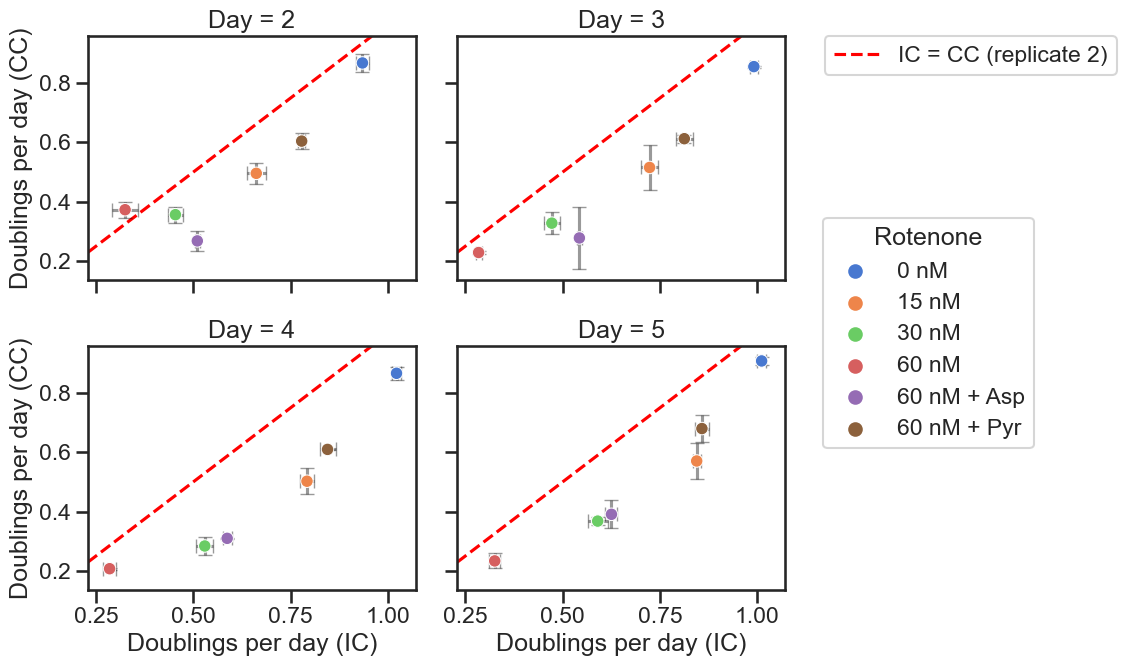

In [33]:
# Compare IC vs CC (rep 2) proliferation rate day-by-day:
mask = (df_IC_CC_inferred_mean['Elapsed'] > 0) & (df_IC_CC_inferred_mean['Rep'] == 2)
df_plot2 = copy.deepcopy(df_IC_CC_inferred_mean[mask])
df_plot2['stdev_IC'] = df_IC_CC_inferred_stdev[mask]['Prlfr_IC'].values
df_plot2['stdev_CC'] = df_IC_CC_inferred_stdev[mask]['Prlfr_CC'].values
sns_fig = sns.FacetGrid(df_plot2, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=True, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='Prlfr_IC', y='Prlfr_CC', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map_dataframe(plt.errorbar, x='Prlfr_IC', y='Prlfr_CC', xerr='stdev_IC', yerr='stdev_CC', fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Add IC = CC lines:
sns_fig.map(plt.axline, xy1=(0.5, 0.5), slope=1, ls='--', c='red');
ax_leg = plt.axline(xy1=(0.5, 0.5), slope=1, ls='--', c='red', visible=False)
legend_elements = [Line2D([0], [0], color=ax_leg.get_color(), lw=ax_leg.get_linewidth(), ls=ax_leg.get_linestyle(), label='IC = CC (replicate 2)')]
sns_fig.axes[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('Doublings per day (IC)', 'Doublings per day (CC)');
# sns_fig.savefig('plots/prlfr_ICvsCC-rep2-byday.pdf', bbox_inches='tight');

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


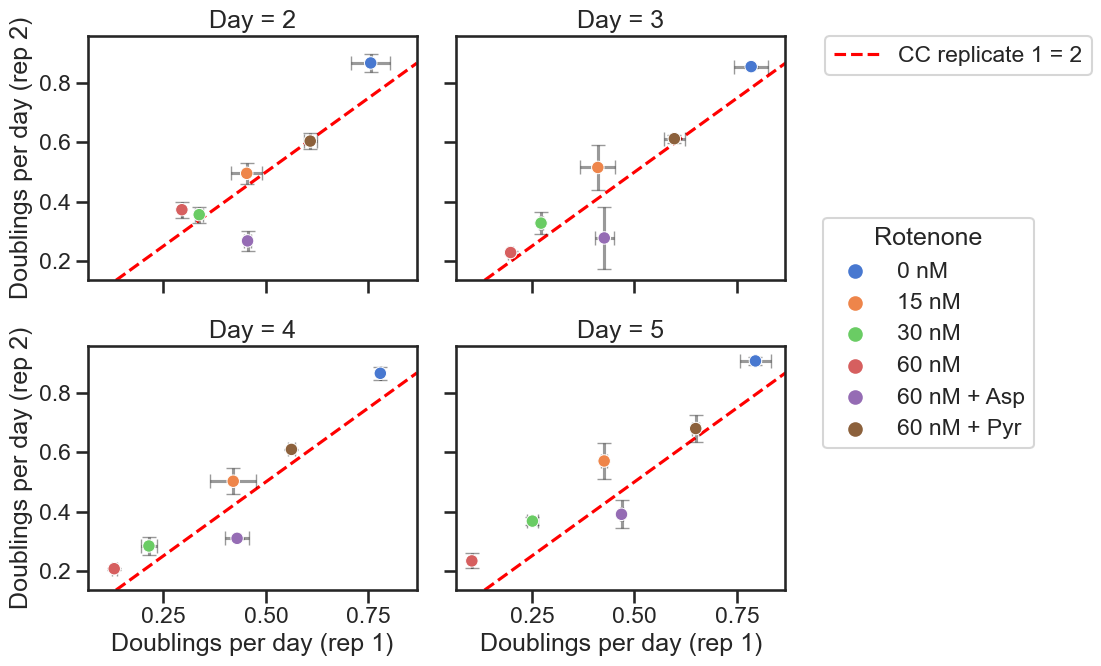

In [34]:
# Plot CC replicate 1 vs 2 to see repeatability:
# Prep data:
df_plot1_ = df_plot1.drop(['Rep', 'Prlfr_IC', 'stdev_IC', 'Elapsed'], axis=1)
df_plot2_ = df_plot2.drop(['Rep', 'Prlfr_IC', 'stdev_IC', 'Elapsed'], axis=1)
df_plot_rVr = df_plot1_.merge(df_plot2_, left_on=['Elapsed_int', 'Treatment'], right_on=['Elapsed_int', 'Treatment']).rename(columns={'Prlfr_CC_x': 'Prlfr_r1', 'Prlfr_CC_y': 'Prlfr_r2', 'stdev_CC_x': 'stdev_r1', 'stdev_CC_y': 'stdev_r2', 'Cell-size_mean_x': 'Cell-size_mean_r1', 'Cell-size_mean_y': 'Cell-size_mean_r2',})
# Plot:
sns_fig = sns.FacetGrid(df_plot_rVr, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=True, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='Prlfr_r1', y='Prlfr_r2', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map_dataframe(plt.errorbar, x='Prlfr_r1', y='Prlfr_r2', xerr='stdev_r1', yerr='stdev_r2', fmt='none', color='black', capsize=5, zorder=10, alpha=0.4)
# Add IC = CC lines:
sns_fig.map(plt.axline, xy1=(0.5, 0.5), slope=1, ls='--', c='red');
ax_leg = plt.axline(xy1=(0.5, 0.5), slope=1, ls='--', c='red', visible=False)
legend_elements = [Line2D([0], [0], color=ax_leg.get_color(), lw=ax_leg.get_linewidth(), ls=ax_leg.get_linestyle(), label='CC replicate 1 = 2')]
sns_fig.axes[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('Doublings per day (rep 1)', 'Doublings per day (rep 2)');
# sns_fig.savefig('plots/prlfr_CCvsCC-byday.pdf', bbox_inches='tight');

#### Conclusions
* Good correlation between Coulter counter and IncuCyte proliferation rate.
* IC proliferation is shifted towards being faster than CC for unknown reasons; maybe due to media differences.
* The two CC replicates show high similarity i.e. good reproducibility.

## Cell size analysis
One feature not captured by IncuCyte imaging is cell size. The most accurate way of determining cell size by volume is by a Coulter counter and thus both of the above described replicates also have cell size data. Here I show relevant cell size analysis by plotting:
* Cell size progression over time.
* Cell size repeatability between replicate experiments.
* Cell size correlation with proliferation rate.

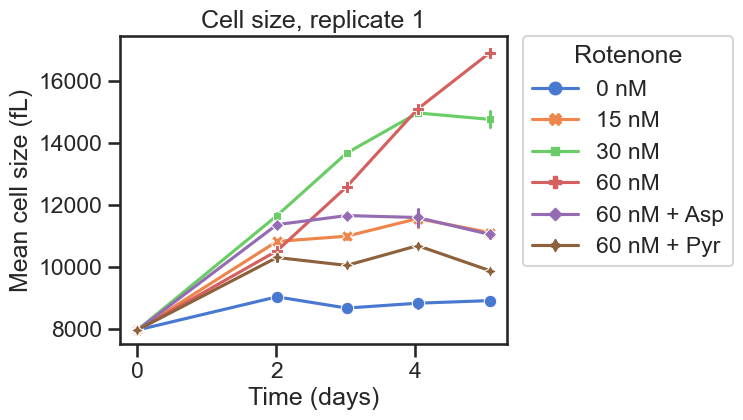

In [35]:
# Mean cell size over time (replicate 1):
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
mask = df_CC['Rep'] == 1
g1 = sns.lineplot(ax=ax1, data=df_CC[mask], x='Elapsed', y='Cell-size_mean', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_title('Cell size, replicate 1');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Mean cell size (fL)');
# fig.savefig('plots/cell-size-time_rep1.pdf', bbox_inches='tight');

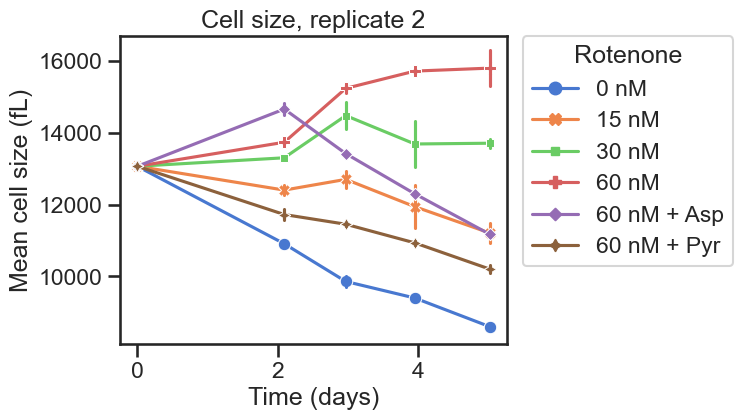

In [36]:
# Mean cell size over time (replicate 2):
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
mask = df_CC['Rep'] == 2
g1 = sns.lineplot(ax=ax1, data=df_CC[mask], x='Elapsed', y='Cell-size_mean', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars")
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_title('Cell size, replicate 2');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Mean cell size (fL)');
# fig.savefig('plots/cell-size-time_rep2.pdf', bbox_inches='tight');

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


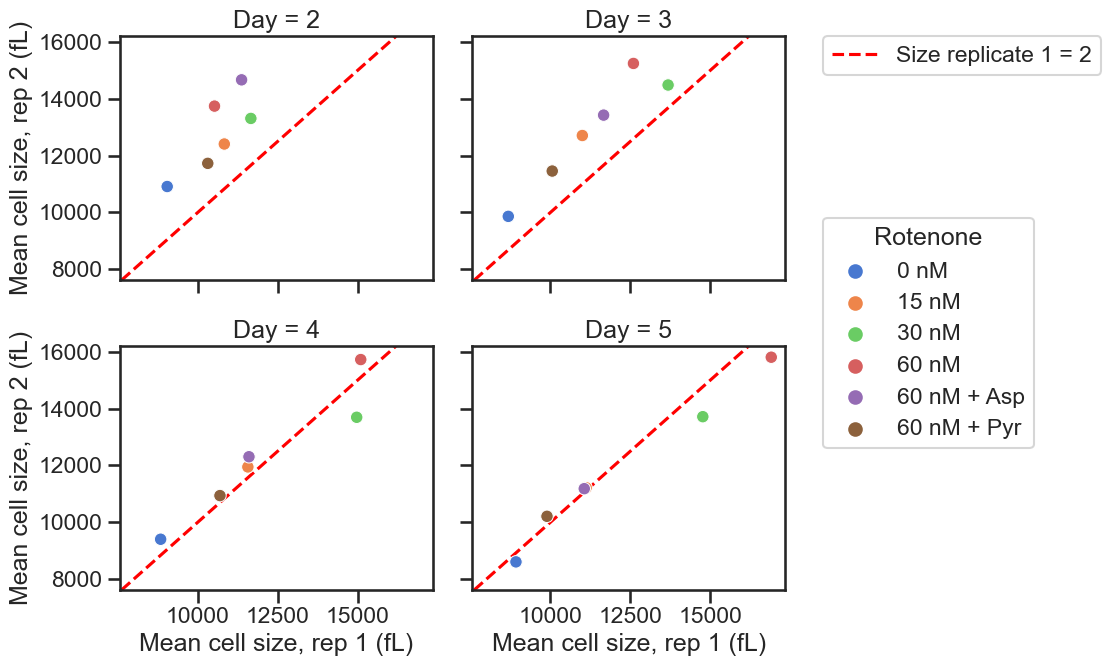

In [37]:
# Plot the correlation in cell size between replicate 1 and 2 by sampling day.
# No errorbar is plotted:
sns_fig = sns.FacetGrid(df_plot_rVr, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=True, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='Cell-size_mean_r1', y='Cell-size_mean_r2', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
sns_fig.map(plt.axline, xy1=(8000, 8000), slope=1, ls='--', c='red');
ax_leg = plt.axline(xy1=(8000, 8000), slope=1, ls='--', c='red', visible=False)
legend_elements = [Line2D([0], [0], color=ax_leg.get_color(), lw=ax_leg.get_linewidth(), ls=ax_leg.get_linestyle(), label='Size replicate 1 = 2')]
sns_fig.axes[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('Mean cell size, rep 1 (fL)', 'Mean cell size, rep 2 (fL)');
# sns_fig.savefig('plots/cell-size-time_rep1-2_byday.pdf', bbox_inches='tight');

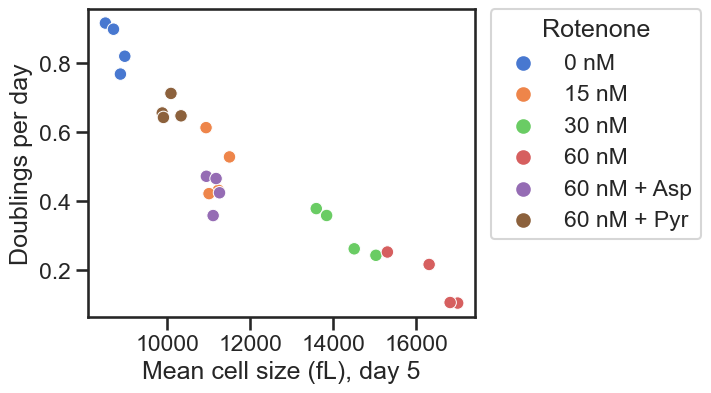

In [38]:
# Mean cell size correlates after day 4.
# Plot proliferation rate as a function of cell size:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
mask = (df_CC['Elapsed'] > 4.5)
g1 = sns.scatterplot(data=df_CC[mask], x='Cell-size_mean', y='Prlfr', hue='Treatment')
g1.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');
g1.set_xlabel('Mean cell size (fL), day 5')
g1.set_ylabel('Doublings per day');
# fig.savefig('plots/cell-size-prlfr.pdf', bbox_inches='tight');

#### Conclusions
* Starting point (t0 count) for cell size is variable between replicates for unknown reasons.
* Cell size after day 4 of rotenone treatment is highly correlated between replicates.
* Cell size at day 5 predicts proliferation rate; larger cells are proliferating slower.
* The "large cell phenotype" is also observed with nucleotide depletion.

/Users/krdav/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


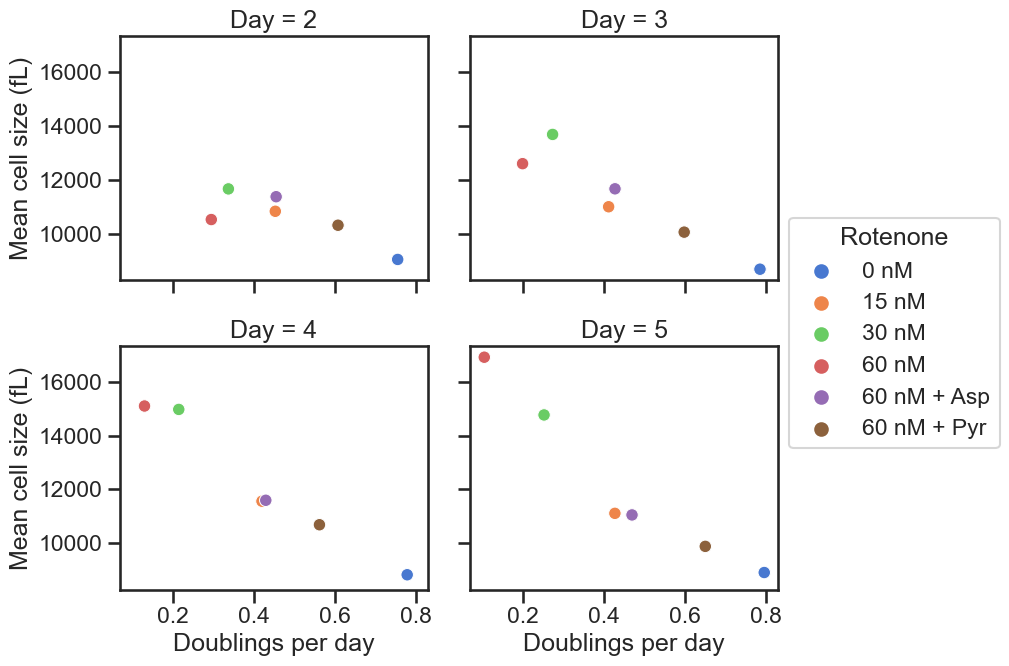

In [39]:
# Plot the correlation in cell size between replicate 1 and 2 by sampling day.
# No errorbar is plotted:
sns_fig = sns.FacetGrid(df_plot_rVr, col='Elapsed_int', aspect=1.2, height=3.5, col_wrap=2, despine=False, sharey=True, sharex=True)
sns_fig.map_dataframe(sns.scatterplot, x='Prlfr_r1', y='Cell-size_mean_r1', hue='Treatment', zorder=20)
sns_fig.add_legend(**dict(loc='center left', bbox_to_anchor=(0.8, 0.5), borderaxespad=0, frameon=True, title='Rotenone'));
#sns_fig.map(plt.axline, xy1=(8000, 8000), slope=1, ls='--', c='red');
#ax_leg = plt.axline(xy1=(8000, 8000), slope=1, ls='--', c='red', visible=False)
#legend_elements = [Line2D([0], [0], color=ax_leg.get_color(), lw=ax_leg.get_linewidth(), ls=ax_leg.get_linestyle(), label='Size replicate 1 = 2')]
#sns_fig.axes[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.12, 1), borderaxespad=0)
sns_fig.set_titles(col_template='Day = {col_name}')
sns_fig.set_axis_labels('Doublings per day', 'Mean cell size (fL)');
#sns_fig.savefig('plots/cell-size-time_rep1-2_byday.pdf', bbox_inches='tight');

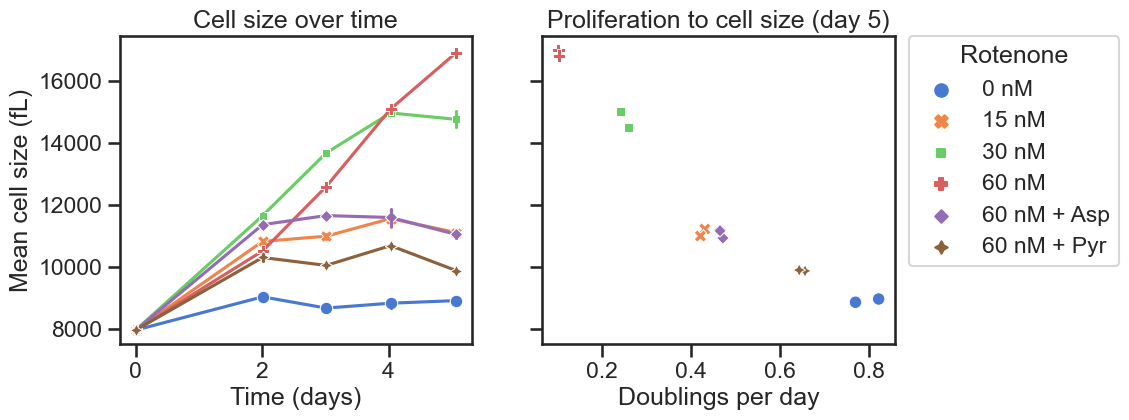

In [40]:
# Mean cell size over time (replicate 1):
plt_out_nam = 'plots/cell-size-time_prlfr'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
mask = (df_CC['Rep'] == 1)
g1 = sns.lineplot(ax=ax1, data=df_CC[mask], x='Elapsed', y='Cell-size_mean', hue='Treatment', style='Treatment', markers=True, errorbar=('ci', 95), dashes=False, err_style="bars", legend=False)
g1.set_title('Cell size over time');
g1.set_xlabel('Time (days)')
g1.set_ylabel('Mean cell size (fL)');

mask &= (df_CC['Elapsed'] > 4.5)
g2 = sns.scatterplot(ax=ax2, data=df_CC[mask], y='Cell-size_mean', x='Prlfr', hue='Treatment', style='Treatment', markers=True)
g2.legend(loc='upper left', bbox_to_anchor=(1.04, 1), borderaxespad=0, title='Rotenone');

g2.set_title('Proliferation to cell size (day 5)');
#g2.set_ylabel('Mean cell size (fL), day 5')
g2.set_xlabel('Doublings per day');
fig.savefig('{}.pdf'.format(plt_out_nam), bbox_inches='tight');
df_CC.loc[(df_CC['Rep'] == 1), ['Elapsed', 'Treatment', 'Prlfr', 'Cell-size_mean']].reset_index(drop=True)\
    .to_excel('{}.xlsx'.format(plt_out_nam), index=False, sheet_name=plt_out_nam.split('/')[-1])